# Implementation of Quantum Vision Transformers paper circuits

This project aims to implement the concepts outlined in the paper *Quantum Vision Transformers* by El Amine Cherrat, Iordanis Kerenidis, Natansh Mathur, Jonas Landman, Martin Strahm, Yun Yvonna Li, harnessing the power of quantum computing to enhance the capabilities of vision transformers. 

This work is primarily based on TensorFlow Quantum, a robust software framework that facilitates the construction, simulation, and training of quantum machine learning models. *TensorFlow Quantum: A Software Framework for Quantum Machine Learning* by Michael Broughton, Guillaume Verdon, Trevor McCourt, Antonio J. Martinez, Jae Hyeon Yoo, Sergei V. Isakov, Philip Massey, Ramin Halavati, Murphy Yuezhen Niu, Alexander Zlokapa, Evan Peters, Owen Lockwood, Andrea Skolik, Sofiene Jerbi, Vedran Dunjko, Martin Leib, Michael Streif, David Von Dollen, Hongxiang Chen, Shuxiang Cao, Roeland Wiersema, Hsin-Yuan Huang, Jarrod R. McClean, Ryan Babbush, Sergio Boixo, Dave Bacon, Alan K. Ho, Hartmut Neven, Masoud Mohseni.

I also draw inspiration and insights from last year's Google Summer of Code (GSoC) projects focused on Quantum Vision Transformers. These projects, documented in detail on [Sal's GSoC blog](https://salcc.github.io/blog/gsoc23/) and [Eyüp B. Ünlü's Medium post](https://medium.com/@eyupb.unlu/gsoc-2023-with-ml4sci-quantum-transformer-for-high-energy-physics-analysis-final-report-cd9ed594e4a2).


In [1]:
import cirq
from cirq import ops
from cirq.contrib.svg import SVGCircuit
import numpy as np
import matplotlib as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import tensorflow_quantum as tfq
import sympy

# RBS GATE

In [2]:
class RBSGate(cirq.Gate):
    def __init__(self, theta):
        super(RBSGate, self).__init__()
        self.theta = theta

    def _num_qubits_(self):
        return 2

    def _decompose_(self, qubits):
        q0, q1 = qubits
        yield cirq.H(q0), cirq.H(q1)
        yield cirq.CZ(q0, q1)
        yield cirq.ry(self.theta / 2)(q0), cirq.ry(-self.theta / 2)(q1)
        yield cirq.CZ(q0, q1)
        yield cirq.H(q0), cirq.H(q1)

    def _unitary_(self):
        cos = np.cos(self.theta)
        sin = np.sin(self.theta)
        return np.array([
            [1, 0, 0,0],
            [0, cos, sin, 0],
            [0, -sin, cos, 0],
            [0, 0, 0, 1]
        ])
    
    def _circuit_diagram_info_(self, args):
        return "[RBS({:.2f})]".format(self.theta), "[RBS({:.2f})]".format(self.theta)

Unitary matrix
[[ 1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.70710678+0.j  0.70710678+0.j  0.        +0.j]
 [ 0.        +0.j -0.70710678+0.j  0.70710678+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  1.        +0.j]]
RBS Gate


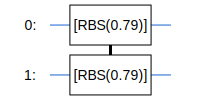

In [3]:
# Define qubits and tetha
q0, q1 = cirq.LineQubit.range(2)
theta = np.pi/4

# Create circuit and apply RBS gate
circuit = cirq.Circuit()
circuit.append(RBSGate(theta)(q0, q1))

print("Unitary matrix")
print(cirq.unitary(circuit))
print("RBS Gate")
SVGCircuit(circuit)

RBS Gate decomposed


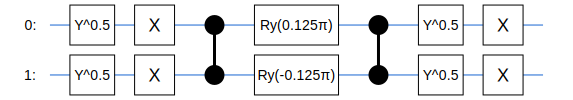

In [4]:
# Decompose the circuit
decomposed_circuit = cirq.decompose(circuit)
    
print("RBS Gate decomposed")
SVGCircuit(cirq.Circuit(decomposed_circuit))

## Functions to convert arrays and matrices to parameters 

In [5]:
def convert_array(X):
    alphas = tf.zeros(X.shape[:-1] + (X.shape[-1]-1,), dtype=X.dtype)
    X_normd = X / (tf.sqrt(tf.reduce_sum(X**2, axis=-1, keepdims=True))+ 1e-10) # 1e-10 is added to prevent divisions by 0
    for i in range(X.shape[-1]-1):
        if i == 0:
            alphas = tf.tensor_scatter_nd_update(alphas, [[i]], [tf.acos(X_normd[..., i])])
        elif i < (X.shape[-1]-2):
            prod_sin_alphas = tf.reduce_prod(tf.sin(alphas[..., :i]), axis=-1)
            updated_value = tf.acos(X_normd[..., i] / (prod_sin_alphas + 1e-10)) # 1e-10 is added to prevent divisions by 0
            alphas = tf.tensor_scatter_nd_update(alphas, [[i]], [updated_value])
        else:
            updated_value = tf.atan2(X_normd[..., -1], X_normd[..., -2])
            alphas = tf.tensor_scatter_nd_update(alphas, [[i]], [updated_value])
    return alphas

def convert_matrix(X):
    mag_alphas = convert_array(tf.sqrt(tf.reduce_sum(X**2, axis=1)))
    alphas = tf.TensorArray(dtype=X.dtype, size=X.shape[0])
    for i in range(X.shape[0]):
        alphas = alphas.write(i, convert_array(X[i]))
    alphas = alphas.stack()
    return mag_alphas, alphas

## Vector loader

In [6]:
def vector_loader(circuit, alphas, wires=None, is_x=True, is_conjugate=False):
    # Loads the vector to the given wires
    # alpha: the parametrized data. Parametrization can be achieved using convert_array function.
    # wires: indicates which wires the operation is performed on. The default is [0,1,2,...,len(alpha)].
    # is_x:  Whether to apply hadamard gate to the first gate or not. The default is True
    # is_conjugate : is True if conjugate is being applied. The default is False
    if wires is None:
        wires = [i for i in range(len(alphas) + 1)]
    if is_x and not is_conjugate:
        circuit.append(cirq.X(cirq.LineQubit(wires[0])))
    if is_conjugate:
        # Make sure to handle the index range correctly
        for i in range(len(wires) - 2, -1, -1):
            rbs_gate = RBSGate(-alphas[i])
            circuit.append(rbs_gate.on(cirq.LineQubit( wires[i]), cirq.LineQubit( wires[i+1])))
    else:
        for i in range(len(wires) - 1):
            rbs_gate = RBSGate(alphas[i])
            circuit.append(rbs_gate.on(cirq.LineQubit(wires[i]), cirq.LineQubit(wires[i+1])))
    if is_x and is_conjugate:
        circuit.append(cirq.X(cirq.LineQubit(wires[0])))

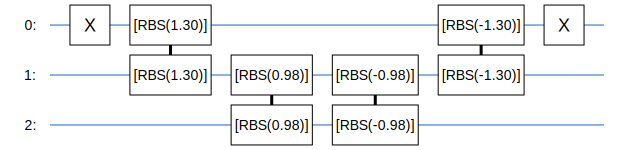

In [7]:
#define array and convert to parameters
array = tf.constant([1.0, 2.0, 3.0])
alphas = convert_array(array)

#Circuit to load the array
circuit = cirq.Circuit()
qubits = [cirq.LineQubit(i) for i in range(4)]
vector_loader(circuit, alphas)
vector_loader(circuit, alphas, is_conjugate=True)
SVGCircuit(circuit)

In [8]:
 np.round(cirq.unitary(circuit), decimals=2) #Load <x1| Load|x1> = I

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,
         0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,
         0.+0.j],
       [-0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,
         0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         1.+0.j]])

## Matrix loader

In [9]:
def matrix_loader(circuit, mag_alphas, alphas, mag_wires, wires, is_conjugate=False):
    if not is_conjugate:
        vector_loader(circuit, mag_alphas, wires=mag_wires, is_x=False)
        for i in range(len(mag_wires)):
            circuit.append(cirq.CNOT(cirq.LineQubit(mag_wires[i]), cirq.LineQubit(wires[0])))
            vector_loader(circuit, alphas[i], wires=wires, is_x=False)
            if i != len(mag_alphas):
                vector_loader(circuit, alphas[i+1], wires=wires, is_x=False, is_conjugate=True)
    else:
        for i in reversed(range(len(mag_wires))):
            if i != len(mag_alphas):
                vector_loader(circuit, alphas[i+1], wires=wires, is_x=False, is_conjugate=False)
            vector_loader(circuit, alphas[i], wires=wires, is_x=False, is_conjugate=True)
            circuit.append(cirq.CNOT(cirq.LineQubit(mag_wires[i]), cirq.LineQubit(wires[0])))
        vector_loader(circuit, mag_alphas, wires=mag_wires, is_x=False, is_conjugate=True)

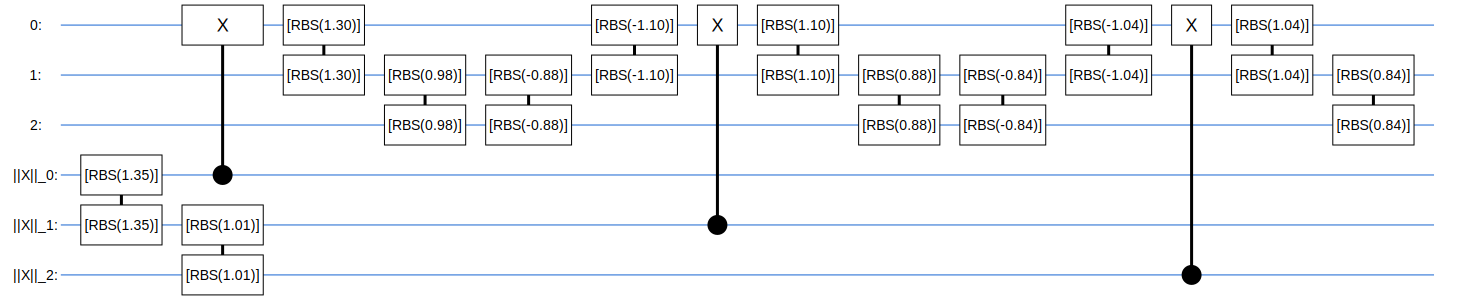

In [10]:
#define matrix and convert to parameters
matrix = tf.constant([
    [1.0, 2.0, 3.0],
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 9.0]
])
mag_alphas, alphas = convert_matrix(matrix)

#Circuit to load the matrix
circuit = cirq.Circuit()
nrow, ncolumn = matrix.shape
mag_wires = ['||X||_'+str(i) for i in range(nrow)]
wires = [str(i) for i in range(ncolumn)]
matrix_loader(circuit, mag_alphas , alphas, mag_wires, wires, is_conjugate=False)

SVGCircuit(circuit)

# Quantum Orthogonal Layers

## Pyramid Circuit 
*Classical and Quantum Algorithms for Orthogonal Neural Networks* by Iordanis Kerenidis, Jonas Landman and Natansh Mathur

In [11]:
def pyramid_circuit(circuit, parameters, wires=None):
    # If wires is None, use all qubits in the circuit
    if wires is None:
        wires = list(circuit.all_qubits())
        length = len(wires)
    else:
        # If wires is not None, ensure it's a list of qubits
        length = len(wires)

    k = 0  

    for i in range(2 * length - 2):
        j = length - abs(length - 1 - i)

        if i % 2:
            for _ in range(j):
                if _ % 2 == 0 and k < len(parameters):
                    circuit.append(RBSGate(parameters[k]).on(wires[_], wires[_ + 1]))
                    k += 1
        else:
            for _ in range(j):
                if _ % 2 and k < len(parameters):
                    circuit.append(RBSGate(parameters[k]).on(wires[_], wires[_ + 1]))
                    k += 1

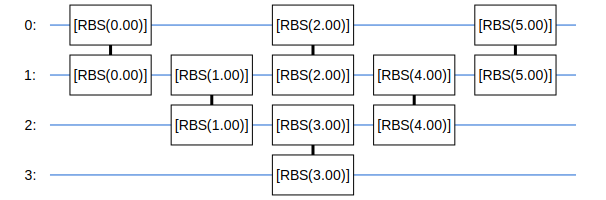

In [12]:
# Example usage
parameters = np.array([x for x in range(6)])  
circuit = cirq.Circuit()
qubits = [cirq.LineQubit(i) for i in range(4)]
# Call the pyramid_circuit function
pyramid_circuit(circuit, parameters, wires=qubits)
SVGCircuit(circuit)

## X Circuit

In [13]:
def x_circuit(circuit, parameters, wires=None):
    # If wires is None, use all qubits in the circuit
    if wires is None:
        wires = list(circuit.all_qubits())
        length = len(wires)
    else:
        # If wires is not None, ensure it's a list of qubits
        length = len(wires)

    k = 0  

    for i in range(len(wires) - 1):
        j = len(wires) - 2 - i
        
        if i == j:
            circuit.append(RBSGate(parameters[k]).on(wires[j], wires[j + 1]))
            k += 1
        else:
            circuit.append(RBSGate(parameters[k]).on(wires[i], wires[i + 1]))
            k += 1
            circuit.append(RBSGate(parameters[k]).on(wires[j], wires[j + 1]))
            k += 1

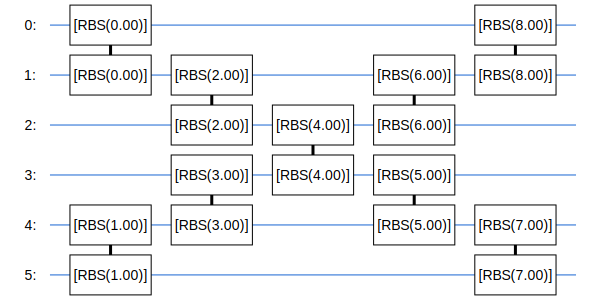

In [14]:
# Example usage
parameters = np.array([x for x in range(9)])  # Example vector of angles
circuit = cirq.Circuit()
qubits = [cirq.LineQubit(i) for i in range(6)]
# Call the x_circuit function
x_circuit(circuit, parameters, wires=qubits)
SVGCircuit(circuit)

## Butterfly Circuit

In [15]:
def butterfly_circuit(circuit, parameters, wires=None):
    # If wires is None, use all qubits in the circuit
    if wires is None:
        wires = list(circuit.all_qubits())
        length = len(wires)
    else:
        # If wires is not None, ensure it's a list of qubits
        length = len(wires)
    if length > 1:
        n=length//2
        x = 0
        for i in range(n):
            circuit.append(RBSGate(parameters[x])(wires[i], wires[i+n]))
            x += 1
        butterfly_circuit(circuit, parameters[x: (len(parameters)//2 + x//2) ], wires = wires[:n])
        butterfly_circuit(circuit, parameters[(len(parameters)//2 + x//2):], wires = wires[n:])

ERROR! Session/line number was not unique in database. History logging moved to new session 39


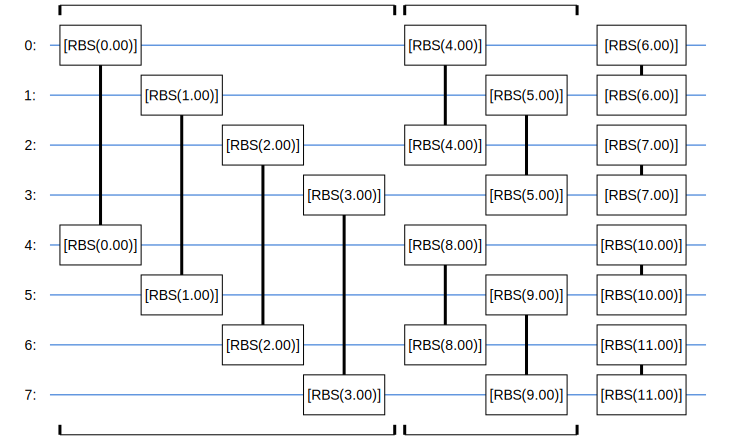

In [16]:
# Example usage
parameters = np.array([x for x in range(12)])
circuit = cirq.Circuit()
qubits = [cirq.LineQubit(i) for i in range(8)]
# Call the butterfly_circuit function
butterfly_circuit(circuit, parameters, wires=qubits)
SVGCircuit(circuit)

# Quantum Transformer

## Orthogonal Patch-wise Neural Network

In [17]:
def orthogonal_patch_wise_NN_circuit(circuit, patch, parameters, wires=None):
    if wires==None:
        wires = list(circuit.all_qubits())[:len(patch)]
    # Load the vector (patch) onto the circuit
    alphas = convert_array(patch)
    vector_loader(circuit, alphas, wires=[qubit.x for qubit in wires])

    # Apply the butterfly circuit to create the orthogonal layer
    butterfly_circuit(circuit, parameters, wires=wires)

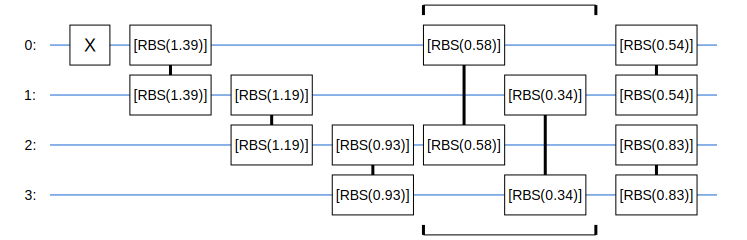

In [18]:
# Example 2x2 patch
patch = tf.constant([[1, 2],
                     [3, 4]], dtype=tf.float32) 

# Flatten the patch
flat_patch = tf.reshape(patch, [-1]) 

parameters = tf.constant(np.random.rand(4), dtype=tf.float32)

# Create the quantum circuit using the orthogonal_patch_wise_NN function
circuit = cirq.Circuit()
Qubits = [cirq.LineQubit(i) for i in range(4)]
orthogonal_patch_wise_NN_circuit(circuit, flat_patch, parameters, wires=Qubits)
SVGCircuit(circuit)

## Quantum Orthogonal Transformer

In [19]:
def build_attention_element_circuit(alpha_j, alpha_i, orthogonal_layer_parameters):
    #define circuit
    circuit = cirq.Circuit()
    Qubits = [cirq.LineQubit(i) for i in range(len(alpha_j))]

    # Load|xj> - W - Load<xi|
    vector_loader(circuit, alpha_j)
    butterfly_circuit(circuit, orthogonal_layer_parameters)
    vector_loader(circuit, alpha_i, is_conjugate=True)
    return circuit

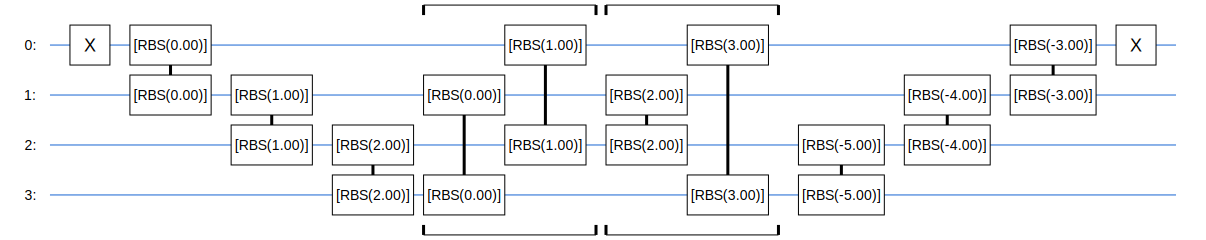

In [20]:
alpha_i_symbols = [i for i in range(3)]
alpha_j_symbols = [j for j in range(3,6)]
parameter_symbols = [k for k in range(4)]

SVGCircuit(build_attention_element_circuit(alpha_i_symbols, alpha_j_symbols, parameter_symbols))

##  Compound Transformer

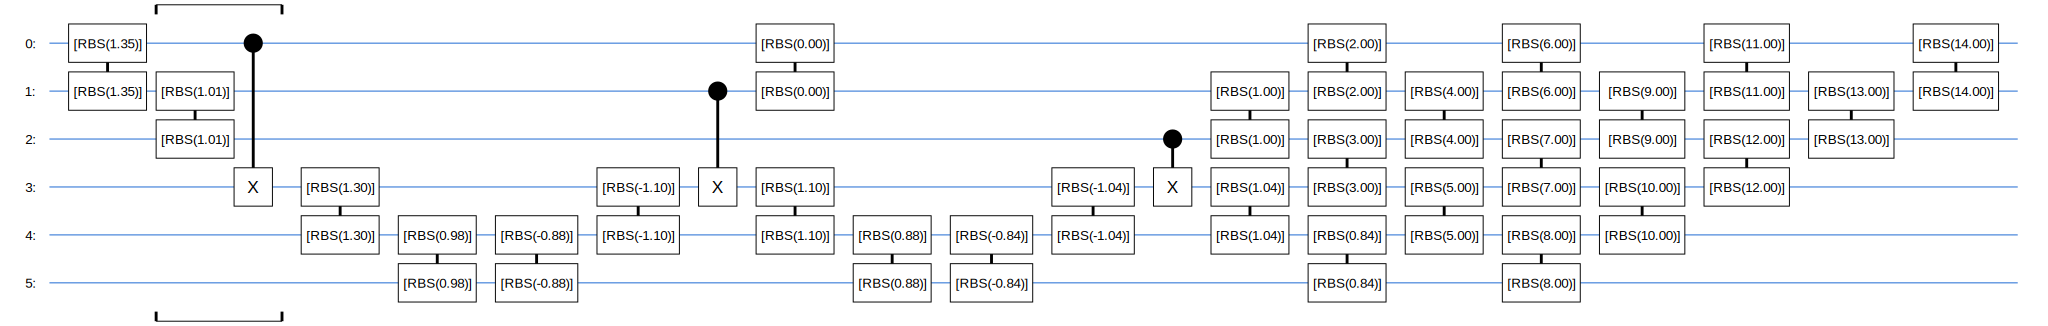

In [21]:
def Compound_transformer(Matrix, orthogonal_layer_parameters):
    circuit = cirq.Circuit()
    N_qubits = matrix.shape[0] + matrix.shape[1]
    
    mag_alphas, alphas = convert_matrix(matrix)
    mag_wires = [i for i in range(matrix.shape[0])]
    wires = [i + matrix.shape[0] for i in range( matrix.shape[1])]
    matrix_loader(circuit, mag_alphas , alphas, mag_wires, wires)
    
    qubits = [cirq.LineQubit(i) for i in range(N_qubits)]
    pyramid_circuit(circuit, orthogonal_layer_parameters, wires=qubits)
    return circuit

#define matrix 
matrix = tf.constant([
    [1.0, 2.0, 3.0],
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 9.0]
])

orthogonal_layer_parameters = np.array([i for i in range(6 * 5 // 2)]) #N(N-1)/2 gates needed for a pyramid circuit

SVGCircuit(Compound_transformer(matrix, orthogonal_layer_parameters))